In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.inspection import permutation_importance

In [3]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [4]:
data = pd.read_csv('CP_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [5]:
param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7023467729657205
Train AUC ROC Score for GS:  0.9293560599754265
Test AUC ROC Score for GS:  0.7613678471229686


Text(0.5, 1.0, 'LUMO')

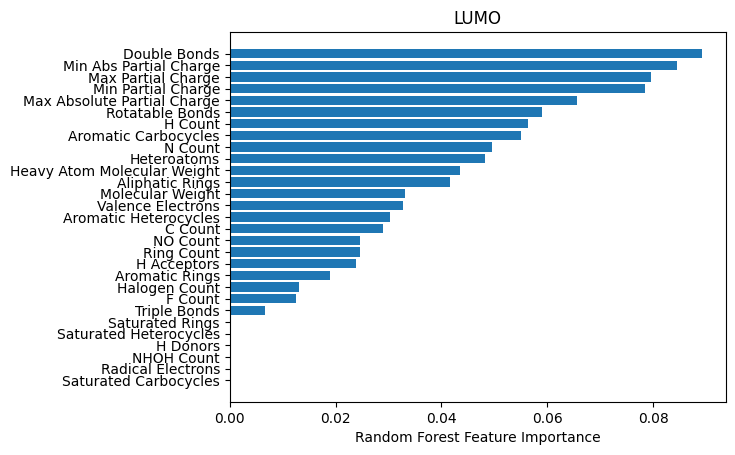

In [6]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [8]:
# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

Mean Absolute Error: 0.17 degrees.
R2:  0.4682815579743116
MSE:  0.05146309246881287
RMSE:  0.2268547827770287


In [9]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Double Bonds0.389 +/- 0.021
Aliphatic Rings0.185 +/- 0.012
Max Partial Charge0.168 +/- 0.009
Aromatic Carbocycles0.129 +/- 0.007
Min Abs Partial Charge0.120 +/- 0.005
Heteroatoms0.112 +/- 0.007
N Count 0.111 +/- 0.006
Min Partial Charge0.098 +/- 0.005
Rotatable Bonds0.098 +/- 0.004
Max Absolute Partial Charge0.075 +/- 0.003
H Count 0.074 +/- 0.003
Heavy Atom Molecular Weight0.072 +/- 0.004
Aromatic Heterocycles0.045 +/- 0.003
Molecular Weight0.041 +/- 0.002
Valence Electrons0.038 +/- 0.002
NO Count0.035 +/- 0.002
C Count 0.032 +/- 0.001
Halogen Count0.032 +/- 0.003
Ring Count0.031 +/- 0.002
H Acceptors0.026 +/- 0.002
Aromatic Rings0.024 +/- 0.002
F Count 0.023 +/- 0.003
Triple Bonds0.006 +/- 0.001
H Donors0.000 +/- 0.000


In [10]:
data = pd.read_csv('CP_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
CV score for GS 0.7191954168569873
Train AUC ROC Score for GS:  0.908913219978817
Test AUC ROC Score for GS:  0.7183935487293756


Mean Absolute Error: 0.14 degrees.
R2:  0.24699788294803104
MSE:  0.04319635376564187
RMSE:  0.207837325246554


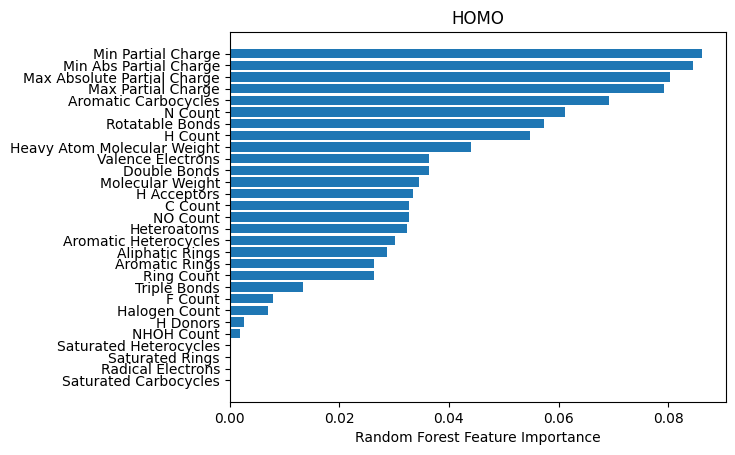

In [11]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

In [12]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Aromatic Carbocycles0.354 +/- 0.022
Min Abs Partial Charge0.168 +/- 0.008
N Count 0.162 +/- 0.011
Max Partial Charge0.150 +/- 0.006
Max Absolute Partial Charge0.140 +/- 0.008
Min Partial Charge0.136 +/- 0.007
Double Bonds0.087 +/- 0.005
Rotatable Bonds0.080 +/- 0.007
H Count 0.065 +/- 0.003
Heavy Atom Molecular Weight0.052 +/- 0.002
Aromatic Heterocycles0.050 +/- 0.005
Aliphatic Rings0.050 +/- 0.004
H Acceptors0.043 +/- 0.003
Heteroatoms0.039 +/- 0.003
Valence Electrons0.038 +/- 0.001
Aromatic Rings0.035 +/- 0.003
Molecular Weight0.035 +/- 0.001
NO Count0.033 +/- 0.002
C Count 0.031 +/- 0.002
Ring Count0.029 +/- 0.002
Triple Bonds0.014 +/- 0.002
F Count 0.008 +/- 0.001
Halogen Count0.008 +/- 0.001
H Donors0.001 +/- 0.000
NHOH Count0.001 +/- 0.000
Saturated Heterocycles0.000 +/- 0.000
